In [1]:
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.display import HTML
%matplotlib inline

# constants in SI
m = 9.10938291E-31 # mass of electron
q = 1.60217657E-19 # charge of electron
ε = 8.85418782E-12 # permittivity of free space
h = 6.62606957E-34 # plancks magical number
hbar = 1.054571800E-34 # reduced planck
Rydberg = 2.1787E-18 # Rydberg energy (in joules)
avogadro = 6.02214179E23
# units
Å = 1E-10 # m to angstrom

# TODO: cross reference with other sources
# TODO: calculations or experimental??

# effective mass electron, for hole use the value 0.15
# from theoretical calculation https://arxiv.org/pdf/1402.4980.pdf
m_e = 0.12
m_red = (0.12*0.15)/(0.12+0.15)

# lattice spacing from own calculations (no. 208)
d = 6.285*Å

# bulk heat capacity here http://ac.els-cdn.com/0022369790900217/1-s2.0-0022369790900217-main.pdf?_tid=45bc99b2-4c36-11e7-879c-00000aab0f01&acdnat=1496918344_1387c0cce35687bb64363a1ca5d06bd2
heat_cap =  180 # J.mol^-1.K^-1

# bandgap from theoretical calculation https://journals.aps.org/prb/pdf/10.1103/PhysRevB.89.155204
ε_g = 1.67

# values for static dielectric constant
ε_0 = [24.1,24.1,25.7,36,36] 

 # values for optical dielectric constant
ε_inf = [4.5,4.5,6,6,6]

# characteristic phonon frequency
freq = [9e12, 2.25e12,9e12,9e12,1e12]
ω_char = [x*2*math.pi for x in freq]

# Diffusivity D

# D = thermal_conductivity / (density*heat capacity)
thermal_conductivity = 0.3 # W.m-1.k-1 http://pubs.rsc.org/en/content/articlepdf/2016/cp/c6cp04246e
# mass per unit cell = 1000amu * 1.66054e-27 = 1.66e-24 kg
# volume of unit cell = d**3
density = (1.66e-24) / (d**3) # kg.m-3 right ball park: https://arxiv.org/pdf/1401.2658.pdf
# mole = 1g
heat_capacity_kg = heat_cap*1000
D = thermal_conductivity / (density*heat_capacity_kg)

The idea in this notebook is to model hot carrier cooling under laser-fluence. Two ways to do this:

- plonk two in under initial conditions (extreme where perfect conductor taking heat away at edges)
- We can make use of symmetry here and model this using boundary conditions (extreme where no heat can escape).

In [120]:
# work out how to space polarons to simulate a given density
# 600AA^3 box. Use 300AA^3 box inside of this.
# At 1x10^18 there would be 3^^3 polarons in box
# At 3x10^17 there would be 2^3 polarons 

box_volume = (300**3)*((1E-10)**3)/((1E-2)**3) # in cm^3
(1**3)/box_volume

# now if using full 600AA box with cyclical boundary conditions (no dissipation)
box_volume_large = (600**3)*((1E-10)**3)/((1E-2)**3) # in cm^3
(6**3)/box_volume_large
# one in box = 1E15
# two^^3 in box = 3.7E16
# three^^3 in box = 1.25E17
# four ^^3 in box = 3E17
# 6^3 in box = 1e18

number_polarons_each_side = 4
step = 1/(number_polarons_each_side+1)

In [121]:
# We can now use this temperature to model heat diffusion 
# Functions are available in heatdiffusion.ipynb so run this to gain access

%run heatdiffusion.ipynb

T = 3.6
r = 2.4e-9

# parameters for finite difference method
# These parameters fix the size of the grid. 
# For example, the total $x$ length of the plate will be $\delta x\times nx$.
dt=1E-10
dx=10*Å 
dy=10*Å
dz=10*Å
nx=60
ny=60
nz=60
nt=900

# it is important that the dimensionless parameter F is < 0.5 for the solution to be stable
# assess_stability(D,dx,dt)

assess_stability(D,dx,dt)
p = initial_conditions_multiple_polarons(r, T, D, dx, dy, dz, dt, nx, ny, nz, nt,step, number_polarons_each_side)
p = step_through(p, D, dx, dy, dz, dt, nx, ny, nz, nt)

SyntaxError: unexpected EOF while parsing (<ipython-input-121-e6c8a5796114>, line 11)

  0%|          | 0/899 [00:00<?, ?it/s]

F is 0.02492622481174699
initial hot cells:3648


100%|██████████| 899/899 [00:24<00:00, 36.97it/s]


In [ ]:
p[:,:,:,1].max()

(0.0, 60.0, 0.0, 60.0)

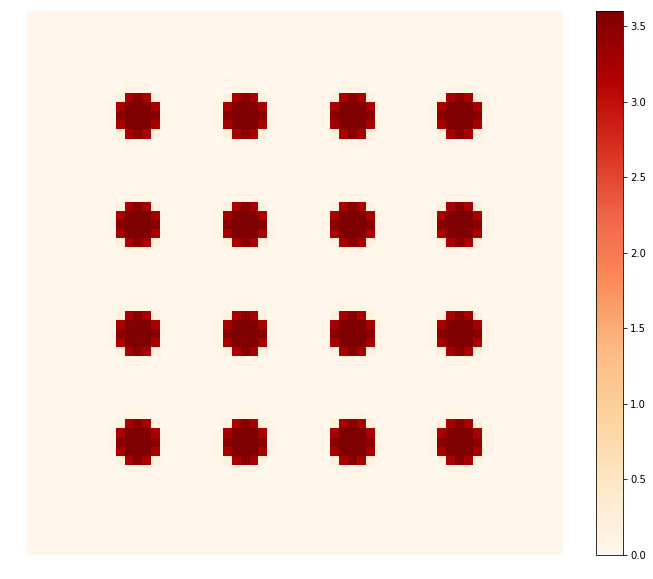

In [126]:
fig = plt.figure(figsize=(12,10))
plt.pcolormesh(p[24,:,:,1],cmap='OrRd')
plt.colorbar()
plt.axis('off')


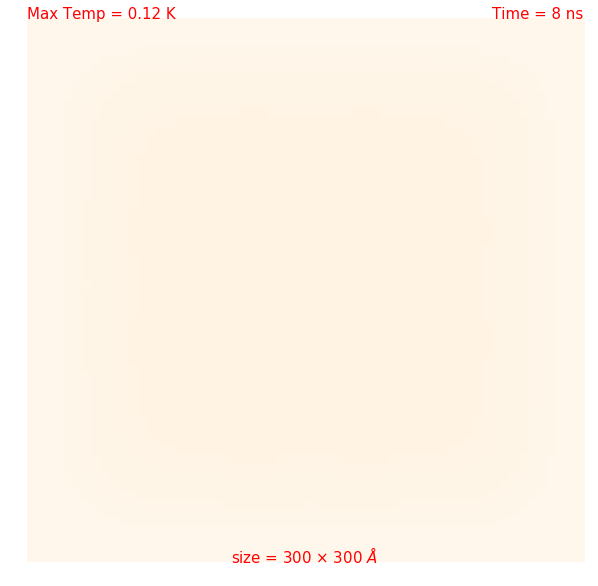

In [127]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mesh = ax.pcolormesh(p[:,:,24,0])
txt = ax.text(0,60,'',fontsize=15,color='red')
txt2 = ax.text(50,60,'',fontsize=15,color='red')
txt3 = ax.text(22,0,r'size = 300 $\times$ 300 $\AA$',fontsize=15,color='red')
plt.axis('off')


def init():
    mesh.set_cmap('OrRd')
    mesh.set_clim(vmin=p.min(),vmax=p.max())

    return mesh,txt,txt2
 
def animate(i):
    data = p[:,:,30,i]
    mesh.set_array(data.ravel())
    mesh.autoscale()
    txt.set_text("Max Temp = %.2f K"%p[:,:,:,i].max())
    txt2.set_text("Time = %.0f ns"%((dt/10E-9)*i))

    return mesh,txt,txt2

anim = animation.FuncAnimation(fig, animate, interval = 10,frames = 800, init_func=init)
HTML(anim.to_html5_video())

In [21]:
p[:,:,:,899].max()

0.042407061823565351

In [59]:
p[:,:,:,899].max()

0.042407061823565351

In [ ]:
# check second from ends are zero so box big enough

In [189]:
%run heatdiffusion.ipynb

T = 3.6
r = 2.4e-9

# parameters for finite difference method
# These parameters fix the size of the grid. 
# For example, the total $x$ length of the plate will be $\delta x\times nx$.
dt=1E-10
dx=10*Å 
dy=10*Å
dz=10*Å
nx=10
ny=10
nz=10
nt=10000

# it is important that the dimensionless parameter F is < 0.5 for the solution to be stable
# assess_stability(D,dx,dt)

assess_stability(D,dx,dt)
p = initial_conditions(r, T, D, dx, dy, dz, dt, nx, ny, nz, nt)
p = step_through_PBCs(p, D, dx, dy, dz, dt, nx, ny, nz, nt)

  7%|▋         | 682/9999 [00:00<00:01, 6813.87it/s]

initial hot cells:23
[[[ 0.  0.  3.  0.]
  [ 0.  3.  3.  0.]
  [ 3.  3.  3.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  3.  3.  0.]
  [ 3.  3.  3.  0.]
  [ 3.  3.  3.  0.]
  [ 0.  0.  0.  0.]]

 [[ 3.  3.  3.  0.]
  [ 3.  3.  3.  0.]
  [ 3.  3.  3.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]
-----
[[[ 0.  3.  3.  0.]
  [ 3.  3.  3.  0.]
  [ 3.  3.  3.  0.]
  [ 0.  0.  0.  0.]]]
F is 0.02492622481174699
initial hot cells:57


100%|██████████| 9999/9999 [00:01<00:00, 7101.57it/s]


In [184]:
p[:,:,:,899].max()

0.00047833590872605424

(0.0, 10.0, 0.0, 10.0)

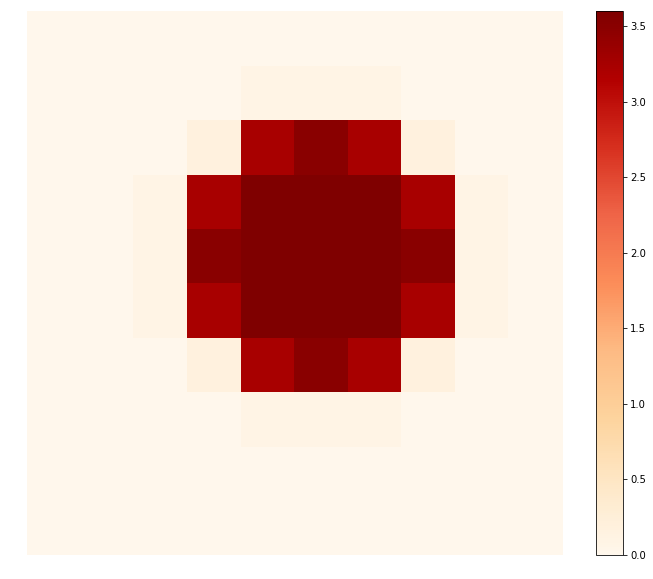

In [190]:
fig = plt.figure(figsize=(12,10))
plt.pcolormesh(p[5,:,:,1],cmap='OrRd')
plt.colorbar()
plt.axis('off')

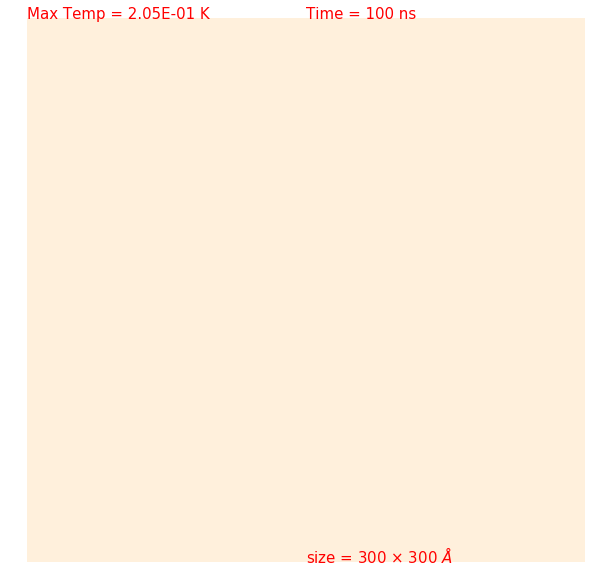

In [191]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mesh = ax.pcolormesh(p[:,:,round(nx/2),0])
txt = ax.text(0,nx,'',fontsize=15,color='red')
txt2 = ax.text(round(nx/2),nx,'',fontsize=15,color='red')
txt3 = ax.text(round(nx/2),0,r'size = 300 $\times$ 300 $\AA$',fontsize=15,color='red')
plt.axis('off')


def init():
    mesh.set_cmap('OrRd')
    mesh.set_clim(vmin=p.min(),vmax=p.max())

    return mesh,txt,txt2
 
def animate(i):
    data = p[:,:,round(nx/2),i]
    mesh.set_array(data.ravel())
    mesh.autoscale()
    txt.set_text("Max Temp = %.2E K"%p[:,:,:,i].max())
    txt2.set_text("Time = %.0f ns"%((dt/10E-9)*i))

    return mesh,txt,txt2

anim = animation.FuncAnimation(fig, animate, interval = 10,frames = nt, init_func=init)
HTML(anim.to_html5_video())

In [170]:
(100**3)*((1E-10)**3)/((1E-2)**3) # in cm^3

9.999999999999999e-19

In [200]:
p[5,5,5,1000]-p[5,5,5,9999]

6.8264499403419832e-05